### Debayan Datta TDFMain
### Persistent Homology from a single grayscale image

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [3]:
def compute_persistence_2DImg_1DHom(f):
    """
    compute persistence diagram in a 2D function (can be N-dim) and critical pts
    only generate 1D homology dots and critical points
    """
    assert len(f.shape) == 2  # f has to be 2D function
    dim = 2

    # pad the function with a few pixels of minimum values
    # this way one can compute the 1D topology as loops
    # remember to transform back to the original coordinates when finished
    padwidth = 2
    padvalue = min(f.min(), 0.0)
    f_padded = np.pad(f, padwidth, 'constant', constant_values=padvalue)
    
    #print("about to call cubePers")
    
    # call persistence code to compute diagrams
    # loads PersistencePython.so (compiled from C++); should be in current dir
    from PersistencePython import cubePers
    #print("cubePers imported success")
    persistence_result = cubePers(np.reshape(
        f_padded, f_padded.size).tolist(), list(f_padded.shape), 0.001)
    #print("Persistence result calculated")

    persistence_result_filtered = [k for k in persistence_result if k[0]==1]
    persistence_result_filtered = np.array(persistence_result_filtered)
    
    # persistence diagram (second and third columns are coordinates)
    dgm = persistence_result_filtered[:, 1:3]
    
    # critical points
    birth_cp_list = persistence_result_filtered[:, 4:4 + dim]
    death_cp_list = persistence_result_filtered[:, 4 + dim:]

    # when mapping back, shift critical points back to the original coordinates
    birth_cp_list = birth_cp_list - padwidth
    death_cp_list = death_cp_list - padwidth
    
    return dgm, birth_cp_list, death_cp_list



In [4]:
def compute_dgm_force(lh_dgm, gt_dgm):
    # get persistence list from both diagrams
    lh_pers = lh_dgm[:, 1] - lh_dgm[:, 0]
    gt_pers = gt_dgm[:, 1] - gt_dgm[:, 0]

    # more lh dots than gt dots
    assert lh_pers.size > gt_pers.size

    # check to ensure that all gt dots have persistence 1
    tmp = gt_pers > 0.999
    assert tmp.sum() == gt_pers.size
    
    gt_n_holes = gt_pers.size  # number of holes in gt

    # get "perfect holes" - holes which do not need to be fixed, i.e., find top
    # lh_n_holes_perfect indices
    # check to ensure that at least one dot has persistence 1; it is the hole
    # formed by the padded boundary
    # if no hole is ~1 (ie >.999) then just take all holes with max values
    tmp = lh_pers > 0.999  # old: assert tmp.sum() >= 1
    if sum(tmp) >= 1:
        # n_holes_to_fix = gt_n_holes - lh_n_holes_perfect
        lh_n_holes_perfect = tmp.sum()
        idx_holes_perfect = np.argpartition(lh_pers, -lh_n_holes_perfect)[
                            -lh_n_holes_perfect:]
    else:
        idx_holes_perfect = np.where(lh_pers == lh_pers.max())[0]

    # find top gt_n_holes indices
    idx_holes_to_fix_or_perfect = np.argpartition(lh_pers, -gt_n_holes)[
                                  -gt_n_holes:]

    # the difference is holes to be fixed to perfect
    idx_holes_to_fix = list(
        set(idx_holes_to_fix_or_perfect) - set(idx_holes_perfect))

    # remaining holes are all to be removed
    idx_holes_to_remove = list(
        set(range(lh_pers.size)) - set(idx_holes_to_fix_or_perfect))

    # only select the ones whose persistence is large enough
    # set a threshold to remove meaningless persistence dots
    # TODO values below this are small dents so dont fix them; tune this value?
    pers_thd = 0.03
    idx_valid = np.where(lh_pers > pers_thd)[0]
    idx_holes_to_remove = list(
        set(idx_holes_to_remove).intersection(set(idx_valid)))

    force_list = np.zeros(lh_dgm.shape)
    # push each hole-to-fix to (0,1)
    force_list[idx_holes_to_fix, 0] = 0 - lh_dgm[idx_holes_to_fix, 0]
    force_list[idx_holes_to_fix, 1] = 1 - lh_dgm[idx_holes_to_fix, 1]

    # push each hole-to-remove to (0,1)
    force_list[idx_holes_to_remove, 0] = lh_pers[idx_holes_to_remove] / \
                                         math.sqrt(2.0)
    force_list[idx_holes_to_remove, 1] = -lh_pers[idx_holes_to_remove] / \
                                         math.sqrt(2.0)

    return force_list, idx_holes_to_fix, idx_holes_to_remove

In [5]:
def compute_topological_loss(lh_dgm, gt_dgm):
    """
    compute persistence loss
    """
    force_list, idx_holes_to_fix, idx_holes_to_remove = \
        compute_dgm_force(lh_dgm, gt_dgm)
    loss = 0.0
    for idx in idx_holes_to_fix:
        loss = loss + force_list[idx, 0] ** 2 + force_list[idx, 1] ** 2
    for idx in idx_holes_to_remove:
        loss = loss + force_list[idx, 0] ** 2 + force_list[idx, 1] ** 2
    return loss

In [6]:
def compute_topological_grad(lh_dgm, lh_bcp, lh_dcp, gt_dgm):
    """
    compute topological gradient
    """
    force_list, idx_holes_to_fix, idx_holes_to_remove = \
        compute_dgm_force(lh_dgm, gt_dgm)

    # each birth/death crit pt of a persistence dot to move corresponds to a row
    # each row has 3 values: x, y coordinates, and the force (increase/decrease)
    topo_grad = np.zeros(
        [2 * (len(idx_holes_to_fix) + len(idx_holes_to_remove)), 3])

    counter = 0
    for idx in idx_holes_to_fix:
        topo_grad[counter] = [lh_bcp[idx, 1], lh_bcp[idx, 0], force_list[idx, 0]]
        counter = counter + 1
        topo_grad[counter] = [lh_dcp[idx, 1], lh_dcp[idx, 0], force_list[idx, 1]]
        counter = counter + 1
    for idx in idx_holes_to_remove:
        topo_grad[counter] = [lh_bcp[idx, 1], lh_bcp[idx, 0], force_list[idx, 0]]
        counter = counter + 1
        topo_grad[counter] = [lh_dcp[idx, 1], lh_dcp[idx, 0], force_list[idx, 1]]
        counter = counter + 1

    topo_grad[:, 2] = topo_grad[:, 2] * -2
    return topo_grad


In [7]:
def save_pers_dgms(fig_fname, lh_dgm, lh_dname, gt_dgm, gt_dname):
    """
    draw both diagrams, with respect names, save the figure to fig_fname
    """
    plt.figure('Diagrams')
    plt.clf()
    plt.plot([0, 1], [0, 1], 'k-')

    force_list, idx_holes_to_fix, idx_holes_to_remove = \
        compute_dgm_force(lh_dgm, gt_dgm)

    plt.scatter([lh_dgm[:, 0]], [lh_dgm[:, 1]], color='green', label=lh_dname)

    for idx in idx_holes_to_fix:
        plt.arrow(lh_dgm[idx, 0], lh_dgm[idx, 1], force_list[idx, 0],
                  force_list[idx, 1], head_width=0.02, head_length=0.03,
                  color='r')

    for idx in idx_holes_to_remove:
        plt.arrow(lh_dgm[idx, 0], lh_dgm[idx, 1], force_list[idx, 0],
                  force_list[idx, 1], head_width=0.02, head_length=0.03,
                  color='c')

    # add small noise to gt persistent dots, so they don't overlap too much
    gt_dgm = gt_dgm + 0.05 * (np.random.random_sample(gt_dgm.shape) - 0.5)

    plt.scatter([gt_dgm[:, 0]], [gt_dgm[:, 1]], color='blue',
                label=gt_dname + ' jittered')
    plt.ylabel('Death Time')
    plt.xlabel('Birth Time')
    plt.title('Persistence Diagrams')
    plt.axis('equal')
    plt.legend()
    plt.savefig(fig_fname)

In [8]:
def draw_critical_pts(fig_fname, lh_img, lh_dgm, lh_bcp, lh_dcp, gt_dgm):
    """
    draw critical points that needs to be pushed up/down
    """
    plt.figure('Critical Pts to Fix/Remove')
    plt.clf()
    plt.imshow(lh_img, 'gray')

    force_list, idx_holes_to_fix, idx_holes_to_remove = \
        compute_dgm_force(lh_dgm, gt_dgm)

    for idx in idx_holes_to_fix:
        plt.scatter(lh_bcp[idx, 1], lh_bcp[idx, 0], marker='v', color='r',
                    label='birth, fix, ' + str(force_list[idx, 0]))
        plt.scatter(lh_dcp[idx, 1], lh_dcp[idx, 0], marker='o', color='r',
                    label='death, fix, ' + str(force_list[idx, 1]))

    for idx in idx_holes_to_remove:
        plt.scatter(lh_bcp[idx, 1], lh_bcp[idx, 0], marker='v', color='c',
                    label='birth, remove, ' + str(force_list[idx, 0]))
        plt.scatter(lh_dcp[idx, 1], lh_dcp[idx, 0], marker='o', color='c',
                    label='death, remove, ' + str(force_list[idx, 1]))

    plt.title('Persistence Pts to Fix/Remove')
    plt.axis('equal')
    # plt.legend(loc=5,bbox_to_anchor=(2, 0.5))
    plt.legend(bbox_to_anchor=(1.1, 0.7), loc=5, borderaxespad=0.)
    plt.tight_layout()
    plt.savefig(fig_fname)


#### Now let us see how this goes
# main function

In [9]:
result_folder = '../../Results1/'

likelihood_fname = '../../Data/20_1.npy'
tmpX = np.load(likelihood_fname)
print(tmpX)
print(tmpX.shape)

likelihood = tmpX
likelihood = likelihood[: ,:]  # crop a piece

[[0.99749255 0.9980038  0.9988079  ... 0.9998888  0.9998765  0.9998964 ]
 [0.9977412  0.99837506 0.998708   ... 0.9998791  0.99988055 0.99989426]
 [0.99794644 0.9982147  0.9982496  ... 0.9998838  0.9998909  0.9999027 ]
 ...
 [0.99999344 0.9999924  0.9999896  ... 0.99927074 0.99944586 0.99943393]
 [0.9999958  0.9999943  0.999992   ... 0.9993231  0.9995067  0.9995252 ]
 [0.9999951  0.9999937  0.9999902  ... 0.9993881  0.9995383  0.9995939 ]]
(1024, 1024)


### Get the GroundTruth

In [10]:
groundtruth = likelihood > 0.9 # approx gt using likelihood
print(groundtruth)
print(groundtruth.shape)

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
(1024, 1024)


In [12]:
# save the loaded (and modified) lh, gt

np.save(result_folder + 'likelihood_cropped.npy', likelihood)
plt.imsave(result_folder + 'likelihood_cropped.png', likelihood, 
           cmap='gray')
np.save(result_folder + 'groundtruth_cropped.npy', groundtruth)
plt.imsave(result_folder + 'groundtruth_cropped.png', groundtruth,
            cmap='gray')

### Compute Persistence for Likelihood and GroundTruth

In [13]:
# compute persistence
pd_lh, bcp_lh, dcp_lh = compute_persistence_2DImg_1DHom(likelihood)
pd_gt, bcp_gt, dcp_gt = compute_persistence_2DImg_1DHom(groundtruth)

In [14]:
print("predicted likelihood:\n",pd_lh[:5])
print(pd_lh.shape)
print("\nBirth critical pts of lh:\n", bcp_lh[:5])
print(bcp_lh.shape)
print("\nDeath critical pts of lh:\n", dcp_lh[:5])
print(dcp_lh.shape)

predicted likelihood:
 [[0.00000000e+00 9.99999881e-01]
 [2.85121059e-04 3.06907430e-04]
 [3.09266325e-04 3.85623862e-04]
 [3.76098789e-04 4.20531520e-04]
 [3.79239733e-04 5.04705065e-04]]
(14669, 2)

Birth critical pts of lh:
 [[ -1. 669.]
 [808.  61.]
 [896. 131.]
 [741. 553.]
 [895. 138.]]
(14669, 2)

Death critical pts of lh:
 [[935. 102.]
 [809.  60.]
 [897. 132.]
 [742. 552.]
 [896. 136.]]
(14669, 2)


In [15]:
print("predicted groundtruth:\n",pd_gt[0:5])
print(pd_gt.shape)
print("\nBirth critical pts of gt:\n", bcp_gt[0:5])
print(bcp_gt.shape)
print("\nDeath critical pts of gt:\n", dcp_gt[0:5])
print(dcp_gt.shape)

predicted groundtruth:
 [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
(427, 2)

Birth critical pts of gt:
 [[517. 224.]
 [516. 513.]
 [529. 536.]
 [531. 388.]
 [531. 200.]]
(427, 2)

Death critical pts of gt:
 [[518. 226.]
 [517. 515.]
 [528. 537.]
 [529. 382.]
 [529. 209.]]
(427, 2)


### Find the total Loss and the Gradient of the Loss

In [16]:
# compute loss (scalar) and gradient of loss (forces at x,y locations in the
# image which corresp. to crit pts from the persistence computation)
topo_loss = compute_topological_loss(pd_lh, pd_gt)
topo_grad = compute_topological_grad(pd_lh, bcp_lh, dcp_lh, pd_gt)
print ('loss = ', topo_loss)
print ('gradient of loss = \n', topo_grad)

loss =  114.56465147083196
gradient of loss = 
 [[ 7.00000000e+02  6.98000000e+02  6.70917869e-01]
 [ 6.44000000e+02  7.75000000e+02 -1.21593475e-05]
 [ 7.10000000e+02  5.26000000e+02  1.63209438e+00]
 ...
 [ 3.78000000e+02  5.02000000e+02  9.35127301e-02]
 [ 8.86000000e+02  2.10000000e+02 -4.29454575e-02]
 [ 8.87000000e+02  2.12000000e+02  4.29454575e-02]]


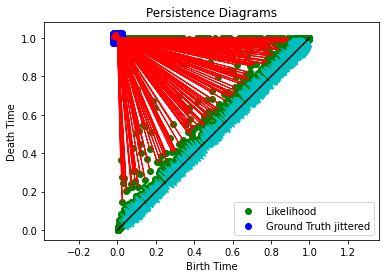

In [17]:
# draw the persistence diagrams of both

dgm_fig_fname = result_folder + 'PersDgms.png'
save_pers_dgms(dgm_fig_fname, pd_lh, 'Likelihood', pd_gt, 'Ground Truth')


/home/althaf/anaconda3/envs/pybind/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


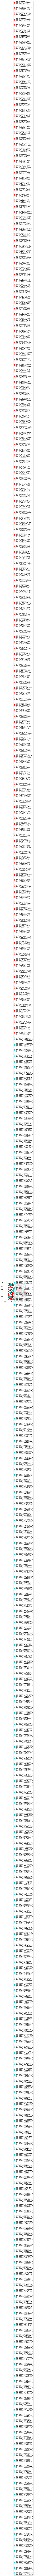

In [18]:
# draw critical pts

cpts_fig_fname = result_folder + 'PersCpts.png'
draw_critical_pts(cpts_fig_fname, likelihood, pd_lh, bcp_lh, dcp_lh, pd_gt)